In [1]:
import keras
import sys
import os
import h5py
import numpy as np
from numpy.linalg import norm

Using TensorFlow backend.


In [2]:
clean_data_filename = 'data/cl/valid.h5'
poisoned_data_filename = 'data/bd/bd_valid.h5'
model_filename = 'models/bd_net.h5'
weights_filename = 'models/bd_weights.h5'

In [3]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    
    return x_data, y_data

In [4]:
def eval(x_test, y_test, bd_model):
    label_p = np.argmax(bd_model.predict(x_test), axis=1)
    accuracy = np.mean(np.equal(label_p, y_test))*100

    return accuracy

In [5]:
cl_x_test, cl_y_test = data_loader(clean_data_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_filename)

bd_model = keras.models.load_model(model_filename)
bd_model.load_weights(weights_filename)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [6]:
layer_num = 5
prune_weights = bd_model.layers[layer_num].get_weights()
weights_shape, channels = prune_weights[0].shape[0:-1], prune_weights[0].shape[-1]

In [7]:
def my_norm(weight_array):
    
    return np.sum(norm(weight_array,ord=1,axis=2))

In [8]:
norms = []
for i in range(channels):
#     print(prune_weights[0][:,:,:,i].shape)
    norms.append(my_norm(prune_weights[0][:,:,:,i]))
    
sorted_ranks = np.argsort(norms)
print(sorted_ranks)

[17 24 53 50 38  0 14 41 48 31 34 33 49 13 45 25 15 12 30 47 37 26 36 55
 40 27  9 44  2 59 35 39 23 56 10 11  8 51 20  7 18 57  5 52  6  4 32 54
 22 58 43  1 46 16 28 19 29 42  3 21]


In [9]:
# Original accuracy and attack success rate
origin_ac = eval(cl_x_test, cl_y_test, bd_model)
origin_asr = eval(bd_x_test, bd_y_test, bd_model)
print('Original Clean Classification accuracy:', origin_ac)
print('Original Attack Success Rate:', origin_asr)

Original Clean Classification accuracy: 98.64899974019225
Original Attack Success Rate: 100.0


In [10]:
ASR = []
CA = []
cnt = 0

for i in sorted_ranks:
    prune_weights[0][:, :, :, i] = np.zeros(weights_shape)
    bd_model.layers[5].set_weights(prune_weights)
    
    clean_accuracy = eval(cl_x_test, cl_y_test, bd_model)       
    CA.append(clean_accuracy)
#     print('Clean Classification accuracy:', clean_accuracy)

    asr = eval(bd_x_test, bd_y_test, bd_model)
    ASR.append(asr)
#     print('Attack Success Rate:', asr)

In [11]:
for i,v in enumerate(zip(CA,ASR)):
#     if v[1] < 100.0:
        print(f'After pruning {i+1} channels, channel={sorted_ranks[i]}, current accuracy={v[0]}, ASR={v[1]}.')

After pruning 1 channels, channel=17, current accuracy=98.64899974019225, ASR=100.0.
After pruning 2 channels, channel=24, current accuracy=98.64899974019225, ASR=100.0.
After pruning 3 channels, channel=53, current accuracy=98.64899974019225, ASR=100.0.
After pruning 4 channels, channel=50, current accuracy=98.64899974019225, ASR=100.0.
After pruning 5 channels, channel=38, current accuracy=98.64899974019225, ASR=100.0.
After pruning 6 channels, channel=0, current accuracy=98.64899974019225, ASR=100.0.
After pruning 7 channels, channel=14, current accuracy=98.64899974019225, ASR=100.0.
After pruning 8 channels, channel=41, current accuracy=98.64899974019225, ASR=100.0.
After pruning 9 channels, channel=48, current accuracy=98.64899974019225, ASR=100.0.
After pruning 10 channels, channel=31, current accuracy=98.64899974019225, ASR=100.0.
After pruning 11 channels, channel=34, current accuracy=98.64899974019225, ASR=100.0.
After pruning 12 channels, channel=33, current accuracy=98.64899

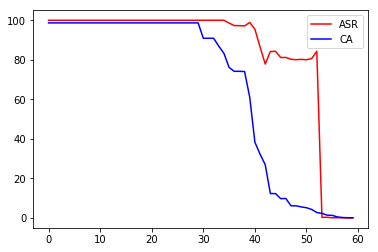

In [19]:
import matplotlib.pyplot as plt

x = np.arange(60)
plt.plot(x, ASR, 'r', x, CA, 'b')
plt.legend(['ASR', 'CA'])

In [13]:
# By looking at the result, we can easily find that the CA drops faster than ASR. CA drops to 90% after pruning 31 channels.
# We also noticed that pruning models once the validation accuracy drops atleast X% for X={2, 4, 10} wold not decrease ASR.
# Let's assume that:
# 2% drops reflects to prune 31 channels
# 4% drops reflects to prune 32 channels
# 10% drops reflects to prune 34 channels
# 30% drops reflects to prune 40 channels

origin_bd_model = keras.models.clone_model(bd_model)
origin_bd_model.load_weights(weights_filename)
bd_prune_weights = origin_bd_model.layers[layer_num].get_weights()

# 2% drops
prune_layer_weights, prune_layer_bias = bd_prune_weights[0], bd_prune_weights[1]
gd_model_2 = keras.models.clone_model(origin_bd_model)
gd_model_2.set_weights(origin_bd_model.get_weights())
for i in range(31):
    prune_layer_weights[:, :, :, sorted_ranks[i]] = np.zeros(weights_shape)
gd_model_2.layers[5].set_weights([prune_layer_weights, prune_layer_bias])


# 4% drops
prune_layer_weights, prune_layer_bias = bd_prune_weights[0], bd_prune_weights[1]
gd_model_4 = keras.models.clone_model(origin_bd_model)
gd_model_4.set_weights(origin_bd_model.get_weights())
for i in range(32):
    prune_layer_weights[:, :, :, sorted_ranks[i]] = np.zeros(weights_shape)
gd_model_4.layers[5].set_weights([prune_layer_weights, prune_layer_bias])


# 10% drops
prune_layer_weights, prune_layer_bias = bd_prune_weights[0], bd_prune_weights[1]
gd_model_10 = keras.models.clone_model(origin_bd_model)
gd_model_10.set_weights(origin_bd_model.get_weights())
for i in range(34):
    prune_layer_weights[:, :, :, sorted_ranks[i]] = np.zeros(weights_shape)
gd_model_10.layers[5].set_weights([prune_layer_weights, prune_layer_bias])

# 30% drops
prune_layer_weights, prune_layer_bias = bd_prune_weights[0], bd_prune_weights[1]
gd_model_30 = keras.models.clone_model(origin_bd_model)
gd_model_30.set_weights(origin_bd_model.get_weights())
for i in range(40):
    prune_layer_weights[:, :, :, sorted_ranks[i]] = np.zeros(weights_shape)
gd_model_30.layers[5].set_weights([prune_layer_weights, prune_layer_bias])

In [14]:
# bd_x_test, bd_y_test

ac_0 = eval(cl_x_test, cl_y_test, origin_bd_model)
ac_2 = eval(cl_x_test, cl_y_test, gd_model_2)
ac_4 = eval(cl_x_test, cl_y_test, gd_model_4)
ac_10 = eval(cl_x_test, cl_y_test, gd_model_10)
ac_30 = eval(cl_x_test, cl_y_test, gd_model_30)
print(f'{ac_0}, {ac_2}, {ac_4}, {ac_10}')

98.64899974019225, 90.88074824629774, 90.88074824629774, 86.89702953148004


In [15]:
new_class = 1283

In [16]:
class gd_model:
    def __init__(self, bd_model, prune_model):
        self.bd = bd_model
        self.gd = prune_model  
        
    def new_eval(self, x_test, y_test):
        label_bd = np.argmax(self.bd.predict(x_test), axis=1)
        label_gd = np.argmax(self.gd.predict(x_test), axis=1)
        final_label = np.argmax(self.gd.predict(x_test), axis=1)
        
        for i, v in enumerate(zip(label_bd, label_gd)):
            if v[0] != v[1]:
                final_label[i] = new_class
                
        accuracy = np.mean(np.equal(final_label, y_test))*100

        return accuracy

In [20]:
fix_2 = gd_model(origin_bd_model, gd_model_2)
asr_2 = fix_2.new_eval(bd_x_test, bd_y_test)
ca_2 = fix_2.new_eval(cl_x_test, cl_y_test)
print(f'2% drop prune model CA = {ca_2}')
print(f'2% drop prune model ASR = {asr_2}')

fix_4 = gd_model(origin_bd_model, gd_model_4)
asr_4 = fix_4.new_eval(bd_x_test, bd_y_test)
ca_4 = fix_4.new_eval(cl_x_test, cl_y_test)
print(f'4% drop prune model CA = {ca_4}')
print(f'4% drop prune model ASR = {asr_4}')

fix_10 = gd_model(origin_bd_model, gd_model_10)
asr_10 = fix_10.new_eval(bd_x_test, bd_y_test)
ca_10 = fix_10.new_eval(cl_x_test, cl_y_test)
print(f'10% drop prune model CA = {ca_10}')
print(f'10% drop prune model ASR = {asr_10}')

fix_30 = gd_model(origin_bd_model, gd_model_30)
asr_30 = fix_30.new_eval(bd_x_test, bd_y_test)
ca_30 = fix_30.new_eval(cl_x_test, cl_y_test)
print(f'30% drop prune model CA = {ca_30}')
print(f'30% drop prune model ASR = {asr_30}')

2% drop prune model CA = 90.70754308478392
2% drop prune model ASR = 100.0
4% drop prune model CA = 90.70754308478392
4% drop prune model ASR = 100.0
10% drop prune model CA = 86.71516411189053
10% drop prune model ASR = 100.0
30% drop prune model CA = 60.83831298172686
30% drop prune model ASR = 98.89148696631159


In [18]:
# This experinemnt shows that using models with validation accuracy drops doesn't work.